# Use case -  Fraud detection with Intel® Optimizitations

This tutorial, will provide a use case where a credit card company might benefit from machine learning techniques to predict fraudulent transactions. 

## Part 1 - Preprocessing and initial data analysis

In this part, you’ll prepare and preprocess data for an accurate representation of fraud and no-fraud examples using the Intel® Distribution of Modin* You’ll also use an anonymized dataset extracted from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) 

### Import Modules and functions

In [1]:
### Import modules and define functions

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import regular pandas
import pandas

In [3]:
# Import Modin 

#USE ONLY ONE OF THESE:

#os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask

import modin.pandas as pd

In [5]:
def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color='blue',width=0.4)
    plt.xlabel("Python Package")
    plt.ylabel("Runtime(seconds)")
    plt.show()
# ****** Do not change the code in this cell! It verifies that the notebook is being run correctly! ******

def verify_and_print_times(pandas_time, modin_time):
    if modin_time < pandas_time:
        print(f"Modin was {pandas_time / modin_time:.2f}X faster than stock pandas!")
        return
    print(
        f"Oops, stock pandas appears to be {modin_time / pandas_time:.2f}X faster than Modin in this case. "
        "This is unlikely but could happen sometimes on certain machines/environments/datasets. "
        "One of the most probable reasons is the excessive amount of partitions being assigned to a single worker. "
        "You may visit Modin's optimization guide in order to learn more about such cases and how to fix them: "
        "\nhttps://modin.readthedocs.io/en/latest/usage_guide/optimization_notes/index.html\n\n"
        "But first, verify that you're using the latest Modin version, also, try to use different executions, "
        "for basic usage we recommend non-experimental 'PandasOnRay'.\n"
        "Current configuration is:"
    )
    try:
        from modin.utils import get_current_execution

        execution = get_current_execution()
    except ImportError:
        # for modin version < 0.12.0
        try:
            from modin.utils import get_current_backend

            execution = get_current_backend()
        except ImportError:
            # for modin versions < 0.8.1
            execution = (
                "Can't deduce the current execution, your Modin version is too old!"
            )
    print(f"\tExecution: {execution}")
    try:
        import modin.config as cfg

        print(
            f"\tIs experimental: {cfg.IsExperimental.get()}\n"
            f"\tNumber of CPUs to utilize by Modin (check that Modin uses all CPUs on your machine): {cfg.CpuCount.get()}\n"
            f"\tIs in debug mode (debug mode may perform slower): {cfg.IsDebug.get()}"
        )
    except (ImportError, AttributeError):
        # for modin versions < 0.8.2
        print("\tCan't deduce Modin configuration, your Modin version is too old!")
    import modin

    print(f"\tModin version: {modin.__version__}")

###  Preprocessing and analysis of data

The first step is to pre-process the data. After you download and extract the data, you’ll have it in spreadsheet format. That means you’ll work with tabular data where each row is a transaction (example) and each column is a feature (transaction amount, credit limit, age.) In this tutorial you won’t know which represents each feature, since the data has been anonymized for privacy purposes. This example uses supervised learning, meaning the algorithm is trained on a pre-defined set of examples. The examples are labeled with one column called LABEL (FRAUD or NOT FRAUD) 

In [6]:
# Locally unzip document donwloaded from Kaggle
!unzip Dataset.csv.zip

Archive:  Dataset.csv.zip
  inflating: Dataset.csv             


Pandas Time(seconds): 0.904883861541748 
Modin Time(seconds): 0.5271012783050537
Modin was 1.72X faster than stock pandas!


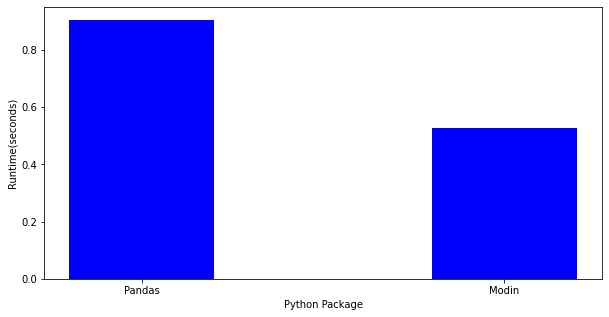

In [11]:
t0 = time.time()
pandas_df = pandas.read_csv("Dataset.csv")
pandas_time = time.time()- t0

t1 = time.time()
modin_df = pd.read_csv("Dataset.csv")
modin_time = time.time() - t1

print("Pandas Time(seconds):",pandas_time,"\nModin Time(seconds):",modin_time)
verify_and_print_times(pandas_time, modin_time)
outputDict={"Pandas":pandas_time,"Modin":modin_time}
plotter(outputDict)

As you can see each feature starts with V. We could learn from the data in a real case scenario where we know wha each feature means. 

In [9]:
modin_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Now that the dataset is loaded on your memory, take a closer look. 

#### Check for Missing values

There are multiple ways to address this problem. There are no good or bad decisions, try them out and see how the algorithm performs with each.

Remove the lines with missing values. If there aren’t very many missing values, a smaller dataset won’t be an issue. Impute value. Simulate a value to fill in the missing field. The idea is to use the example (line) but reduce the effect of missing values. Try replacing with the mean/maximum/minimum value of the feature (column.) You can also impute based on K-means, which will predict the value with an eye to the other values (columns.)
When you’re working with data extracted from outside sources, it’s worth factoring in system failures. These failures take the form of incomplete reporting – taking only partial snapshots of the dataset – and can result in missing values.
Let's check for missing values: 


In [18]:
t0 = time.time()
print(pandas_df.columns[pandas_df.isna().any()])
pandas_time = time.time()- t0

t1 = time.time()
print(modin_df.columns[modin_df.isna().any()])
modin_time = time.time() - t1

print("Pandas Time(seconds):",pandas_time,"\nModin Time(seconds):",modin_time)
verify_and_print_times(pandas_time, modin_time)
outputDict={"Pandas":pandas_time,"Modin":modin_time}

Index([], dtype='object')
Index([], dtype='object')
Pandas Time(seconds): 0.02335381507873535 
Modin Time(seconds): 0.23135614395141602
Oops, stock pandas appears to be 9.91X faster than Modin in this case. This is unlikely but could happen sometimes on certain machines/environments/datasets. One of the most probable reasons is the excessive amount of partitions being assigned to a single worker. You may visit Modin's optimization guide in order to learn more about such cases and how to fix them: 
https://modin.readthedocs.io/en/latest/usage_guide/optimization_notes/index.html

But first, verify that you're using the latest Modin version, also, try to use different executions, for basic usage we recommend non-experimental 'PandasOnRay'.
Current configuration is:
	Execution: PandasOnDask
	Is experimental: None
	Number of CPUs to utilize by Modin (check that Modin uses all CPUs on your machine): 8
	Is in debug mode (debug mode may perform slower): None
	Modin version: 0.15.2


Fortunately, in this example there are no missing values, so you can move on to sub-sampling.

#### Sub sampling

Take a look at the distribution of your data.

<AxesSubplot:xlabel='Class', ylabel='count'>

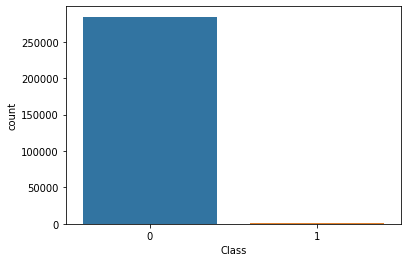

In [19]:
sub_sample_plot=sns.countplot(pandas_df["Class"])
sub_sample_plot

It’s clear that the class (FRAUD or NO FRAUD) is very unbalanced. That means that most cases aren't fraud and just a few are FRAUD.

To train a model with the entire dataset, the model should learn how to detect the majority of cases (NO FRAUD), which is not what we want: We want to detect fraud.

If a model is trained with this data, it would reach high levels of accuracy, but that’s not the outcome you want. (Part three of this tutorial explains how to select a metric based on the criteria you’re seeking.)

Here are some ways to solve this problem:



1.	Obtain more FRAUD examples. Ask the dataset owner for more examples. Usually, however, you need to work with the dataset you have. 
2.	Increase FRAUD examples: If there are examples of the class you want to detect, use an algorithm to generate a considerable number of examples of the desired class. This solution is used mainly in computer vision scenarios but works for others as well. 
3.	Use a different dataset where the ratio of FRAUD to NO FRAUD is close to 1:1.


Now you’re ready to create a new dataset with a useful ratio for generalizing both classes.
First, create a NEW balanced dataset. 



In [20]:
### GET NEW DATA SET 1.1

#PANDAS
t0 = time.time()
pandas_df_sub = pandas_df.sample(frac=1)  #Shuffling the dataframe

pandas_df_sub_nf = pandas_df_sub.loc[pandas_df["Class"] == 0][:492]
pandas_df_sub_f = pandas_df_sub.loc[pandas_df["Class"]==1]

# Will reuse all fraud points, will random sample out 500 non-fraud points

# New sample Table
pandas_df_sub_distributed = pd.concat([pandas_df_sub_nf,pandas_df_sub_f])
pandas_balanced = pandas_df_sub_distributed.sample(frac=1, random_state=42)

# CALCULATE TIME 
pandas_time = time.time()- t0

# MODIN
t1 = time.time()
modin_df_sub = modin_df.sample(frac=1)  #Shuffling the dataframe

modin_df_sub_nf = modin_df_sub.loc[modin_df["Class"] == 0][:492]
modin_df_sub_f = modin_df_sub.loc[modin_df["Class"]==1]

# Will reuse all fraud points, will random sample out 492 non-fraud points

# New sample Table
modin_df_sub_distributed = pd.concat([modin_df_sub_nf,modin_df_sub_f])
modin_balanced = modin_df_sub_distributed.sample(frac=1, random_state=42)

modin_balanced.head()

# CALCULATE TIME 
modin_time = time.time()- t1

print("Pandas Time(seconds):",pandas_time,"\nModin Time(seconds):",modin_time)
verify_and_print_times(pandas_time, modin_time)
outputDict={"Pandas":pandas_time,"Modin":modin_time}


Pandas Time(seconds): 0.4385099411010742 
Modin Time(seconds): 1.3224921226501465
Oops, stock pandas appears to be 3.02X faster than Modin in this case. This is unlikely but could happen sometimes on certain machines/environments/datasets. One of the most probable reasons is the excessive amount of partitions being assigned to a single worker. You may visit Modin's optimization guide in order to learn more about such cases and how to fix them: 
https://modin.readthedocs.io/en/latest/usage_guide/optimization_notes/index.html

But first, verify that you're using the latest Modin version, also, try to use different executions, for basic usage we recommend non-experimental 'PandasOnRay'.
Current configuration is:
	Execution: PandasOnDask
	Is experimental: None
	Number of CPUs to utilize by Modin (check that Modin uses all CPUs on your machine): 8
	Is in debug mode (debug mode may perform slower): None
	Modin version: 0.15.2


In [21]:
#The resulting balanced dataset makes it easier to train the algorithm.

print('No Frauds', round(modin_balanced['Class'].value_counts()[0]/len(modin_balanced) * 100,2), '% of the dataset')
print('Frauds', round(modin_balanced['Class'].value_counts()[1]/len(modin_balanced) * 100,2), '% of the dataset')

#sub_sample_plot=sns.countplot(modin_balanced["Class"])
#sub_sample_plot

No Frauds 50.0 % of the dataset
Frauds 50.0 % of the dataset


Now you have the data necessary to demonstrate a fair representation of FRAUD and NO FRAUD examples. It should also be clear what advantages the Intel® Distribution of Modin provides — with no code changes.


## Part 2 - Data Transformation

#### Split data

A common mistake that can be done is to do all the preprocessing transformations to data before doing the separation between Train/Test/Valid sub samples. Because in a real case scenario de info that we have available is the training data while Test data will be what we are looking to predict, we’ll be transforming the training data with info that is present in test therefore there will be leaked data and the results will be biased. In resume, we could use the entire data to visualize it, but it must be divided as soon as we start working on transformations. 

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
# Split of Data

data = modin_balanced.drop('Class', axis=1)       # Data whithout the label
labels = modin_balanced['Class']                    # Label

# Stratify will balance the data for train and test, test_size (20%), random_state ( it's a random seed to shuffle the data)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=4,stratify=labels)

In [24]:
# Now that we have the train data and test, we'll focus on TRAIN data and TEST data will be used at the end of part 3 of this tutorial to verify the most real scenario performance

#### Scaling

In [25]:
# create list of column names to use later
col_names = list(X_train.columns)

In [26]:
X_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,...,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000
mean,87308.590851,-2.291426,1.791328,-3.356106,2.292644,-1.502895,-0.697463,-2.688407,0.243095,-1.312837,...,0.181585,0.405502,-0.017708,-0.002603,-0.029157,0.007357,0.014952,0.081577,0.043965,103.586557
std,48151.376393,5.316830,3.568666,5.987156,3.140819,4.094094,1.719691,5.672757,4.948775,2.254574,...,0.998783,2.924874,1.201339,1.240150,0.541629,0.666629,0.466151,0.971632,0.405105,220.644740
min,260.000000,-29.876366,-8.402154,-30.558697,-3.722507,-21.665654,-6.406267,-41.506796,-38.987263,-13.434066,...,-3.493050,-21.453736,-8.887017,-19.254328,-2.307453,-4.781606,-1.152671,-7.263482,-1.796363,0.000000
25%,45177.000000,-2.789009,-0.179972,-5.093864,-0.062235,-1.741748,-1.539372,-2.987206,-0.200752,-2.257326,...,-0.183045,-0.179189,-0.553819,-0.207802,-0.373465,-0.328255,-0.293797,-0.053358,-0.051515,1.520000
50%,79294.000000,-0.801931,0.984405,-1.188498,1.401166,-0.497317,-0.626831,-0.657817,0.154563,-0.765079,...,0.014441,0.148284,0.016430,-0.009364,0.011580,0.057425,-0.018519,0.050750,0.039347,20.000000
75%,135098.500000,1.074218,2.787293,0.350978,4.177147,0.447934,0.060591,0.251042,0.862115,0.123667,...,0.431632,0.643157,0.558279,0.200205,0.368764,0.371163,0.329961,0.423333,0.227508,99.990000
max,171914.000000,2.338892,21.467203,3.453140,12.114672,11.095089,6.065901,5.802537,19.587773,3.353525,...,10.440718,27.202839,8.361985,5.303607,1.091435,2.156042,2.745261,3.052358,1.779364,2125.870000


<AxesSubplot:ylabel='Density'>

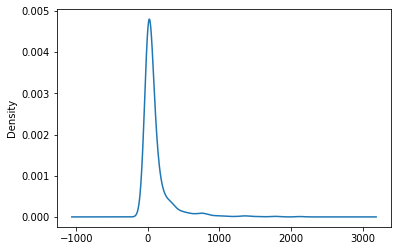

In [27]:
X_train['Amount'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

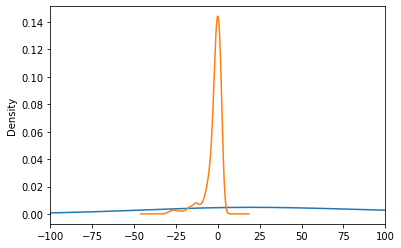

In [28]:
X_train['Amount'].plot(kind='kde',xlim=(100,100))
X_train['V1'].plot(kind='kde',xlim=(-100,100))

In [29]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

In [30]:
standard = StandardScaler()
data_st = standard.fit_transform(X_train)

# convert the array back to a dataframe
dataset_std = DataFrame(data_st, columns=col_names)
dataset_std.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,...,7.870000e+02,787.000000,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02,7.870000e+02
mean,-1.083420e-16,-4.965674e-17,4.062824e-16,-7.583938e-16,1.670272e-16,-1.128562e-16,-4.604534e-16,-2.708549e-16,3.159974e-17,4.694819e-16,...,1.512273e-16,0.000000,-4.514249e-18,1.579987e-17,-1.128562e-16,-3.159974e-17,-5.417098e-17,7.674223e-17,-1.354275e-17,3.114832e-16
std,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,...,1.000636e+00,1.000636,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00,1.000636e+00
min,-1.808961e+00,-5.191530e+00,-2.858201e+00,-4.546381e+00,-1.916371e+00,-4.927972e+00,-3.321780e+00,-6.847301e+00,-7.932328e+00,-5.379703e+00,...,-3.681452e+00,-7.478317,-7.387548e+00,-1.553358e+01,-4.209053e+00,-7.188414e+00,-2.506412e+00,-7.564318e+00,-4.545735e+00,-4.697707e-01
25%,-8.755385e-01,-9.364597e-02,-5.527424e-01,-2.904322e-01,-7.502424e-01,-5.837804e-02,-4.898809e-01,-5.270600e-02,-8.974526e-02,-4.191878e-01,...,-3.653061e-01,-0.200030,-4.465456e-01,-1.655682e-01,-6.360933e-01,-5.037666e-01,-6.627597e-01,-1.389628e-01,-2.358435e-01,-4.628774e-01
50%,-1.665516e-01,2.803253e-01,-2.262569e-01,3.622733e-01,-2.840166e-01,2.457727e-01,4.109883e-02,3.581824e-01,-1.790102e-02,2.431085e-01,...,-1.674546e-01,-0.087997,2.843420e-02,-5.455208e-03,7.526083e-02,7.515340e-02,-7.184891e-02,-3.174745e-02,-1.140743e-02,-3.790696e-01
75%,9.931243e-01,6.334197e-01,2.792637e-01,6.195667e-01,6.003854e-01,4.768012e-01,4.410889e-01,5.184990e-01,1.251651e-01,6.375565e-01,...,2.505104e-01,0.081305,4.797588e-01,1.636388e-01,7.351425e-01,5.460856e-01,6.761941e-01,3.519574e-01,4.533634e-01,-1.631058e-02
max,1.758189e+00,8.714332e-01,5.517016e+00,1.138032e+00,3.129207e+00,3.079068e+00,3.935397e+00,1.497745e+00,3.911469e+00,2.071048e+00,...,1.027816e+01,9.167702,6.979729e+00,4.281404e+00,2.070246e+00,3.225257e+00,5.860858e+00,3.059462e+00,4.286552e+00,9.171166e+00


<AxesSubplot:ylabel='Density'>

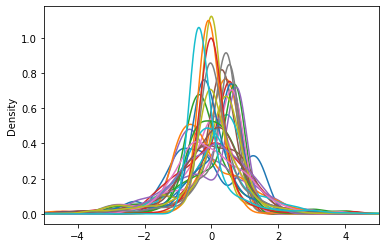

In [31]:
dataset_std.plot(kind='kde',xlim=([-5,5]),legend=False)

#### Outliers

In [32]:
# Concatenate TRAIN dataset (scaled) --> data + labels

y_train= y_train.reset_index(drop=True)
X_train = pd.concat([dataset_std,y_train],axis=1)
X_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.931710,-0.292010,0.444085,-0.357122,1.224578,1.050983,-1.133889,0.179829,-0.578419,-1.168593,...,-0.575883,0.614172,0.366098,-0.422950,0.973831,1.162860,0.677443,-0.610144,-0.465236,1
1,0.620759,0.816150,-0.596167,0.071255,-1.072022,0.993595,2.142962,0.436986,0.084939,0.729039,...,-0.187259,-0.386615,0.217291,1.337165,-0.079599,-0.326664,-0.124055,-0.266011,-0.379070,0
2,-0.957624,-1.262819,1.352052,-1.515460,1.665365,-2.141849,-0.823779,-1.286944,1.071420,-2.694402,...,0.468827,-1.005393,0.068742,0.889082,0.685179,-0.669480,0.458210,-1.222328,1.612137,1
3,0.077148,0.806494,-0.601160,0.475632,-0.625877,0.318048,0.583610,0.330068,-0.010575,1.716217,...,-0.254300,-0.580185,0.293389,0.139284,-0.673477,-1.483726,-0.094791,-0.229746,-0.443876,0
4,1.525878,0.825290,-0.799376,0.464408,-1.037969,0.138329,0.327781,0.279984,-0.036556,0.505778,...,-0.007266,0.926735,0.119476,1.546242,-0.259363,-0.346147,-0.084103,-0.224848,-0.333946,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,1.521763,0.538062,0.425656,-0.547379,1.306837,0.354082,-0.988639,-0.018359,0.054941,-0.989261,...,0.071405,-0.289311,-0.143466,-0.912854,0.957207,0.496965,0.845609,1.061156,-0.448501,1
783,0.705089,-0.063517,0.135798,-0.065058,-0.339521,0.090414,-0.325201,0.165102,0.007813,-0.212817,...,0.159160,1.072136,-0.212118,-0.833926,0.243630,0.174150,-0.011885,0.048915,0.186089,1
784,0.136727,-1.458413,1.219117,-1.607271,1.735654,-1.755303,-1.827051,-1.626221,1.130327,-1.960915,...,0.827204,0.975126,-0.455670,1.611295,0.814434,0.212383,-0.400563,0.043634,-0.465236,1
785,-0.817705,0.624347,-0.790459,0.571083,-0.580405,0.240951,0.910372,0.374053,-0.013814,0.408356,...,-0.259000,-0.637702,-0.206178,-2.483223,0.691692,-0.535836,-0.034841,0.001202,0.334884,0


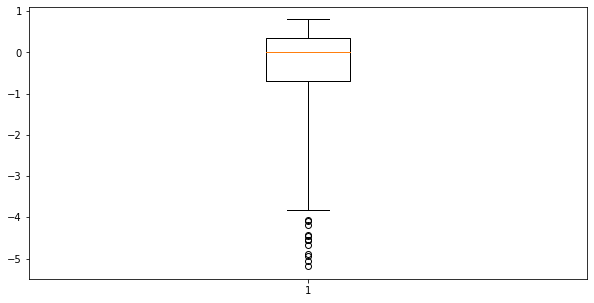

In [33]:
# Example to plot the outliers for 1 feature. You'll be using V5 

fig = plt.figure(figsize =(10,5))
 
# Creating plot
plt.boxplot(X_train['V1'].loc[X_train['Class'] == 1],whis=3)    # "whis" is to define the range of IQR
 
# show plot
plt.show()

In [34]:
## # Example to plot the outliers for 1 feature

# # V1
v1_fraud = X_train['V1'].loc[X_train['Class'] == 1].values
q25, q75 = np.percentile(v1_fraud, 25), np.percentile(v1_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v1_iqr = q75 - q25
print('iqr: {}'.format(v1_iqr))

v1_cut_off = v1_iqr * 3
v1_lower, v1_upper = q25 - v1_cut_off, q75 + v1_cut_off
print('Cut Off: {}'.format(v1_cut_off))
print('V5 Lower: {}'.format(v1_lower))
print('V5 Upper: {}'.format(v1_upper))

outliers = [x for x in v1_fraud if x < v1_lower or x > v1_upper]

print('Feature V5 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V5 outliers:{}'.format(outliers))

Quartile 25: -0.6893563175489766 | Quartile 75: 0.35258934145246884
iqr: 1.0419456590014455
Cut Off: 3.1258369770043366
V5 Lower: -3.815193294553313
V5 Upper: 3.4784263184568056
Feature V5 Outliers for Fraud Cases: 13
V5 outliers:[-4.4292409026773525, -4.54813961123235, -4.082717450164329, -5.0642982754017325, -5.191529500732111, -4.0694218066414125, -4.886395884145655, -4.677233439377554, -4.451157410726059, -4.54813961123235, -4.9370625194319615, -4.196673160286453, -4.54813961123235]


In [35]:
# Let's remove the outliers
for feature in X_train.columns.difference(['Class']):      # Loop into each feature except class
    
    feature_fraud = X_train[feature].loc[X_train['Class'] == 1].values
    q25, q75 = np.percentile(feature_fraud, 25), np.percentile(feature_fraud, 75)   
    feature_iqr = q75 - q25
    
    feature_cut_off = feature_iqr * 3
    feature_lower, feature_upper = q25 - feature_cut_off, q75 + feature_cut_off
    
    outliers = [x for x in feature_fraud if x < feature_lower or x > feature_upper]

    X_train = X_train.drop(X_train[(X_train[feature] > feature_upper) | (X_train[feature] < feature_lower)].index)

print('Number of Instances after outliers removal: {}'.format(len(X_train)))

Number of Instances after outliers removal: 645


In [36]:
## This is the ratio FRAUD vs NO FRAUD
print('No Frauds', round(X_train['Class'].value_counts()[0]/len(X_train) * 100,2), '% of the dataset')
print('Frauds', round(X_train['Class'].value_counts()[1]/len(X_train) * 100,2), '% of the dataset')

No Frauds 57.98 % of the dataset
Frauds 42.02 % of the dataset


This is not a 50/50 ratio anymore. You can divide again to get 50/50 if you want. 57/42 is still a good ratio between FRAUD VS NO FRAUD CASES

## Part 3 - Training

THIS PART SHOULD BE DONE IN PARALLEL, SK LEARN + SKLEARN PATCHED

In [37]:
import numpy as np

# Turn on scikit-learn optimizations with these 2 simple lines:

from sklearnex import patch_sklearn

patch_sklearn()


ModuleNotFoundError: No module named 'sklearnex'

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,...,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000
mean,0.011352,0.030801,-0.088349,0.063020,0.032736,0.057808,0.040946,0.045894,0.030601,0.004702,...,0.049065,0.028752,0.038811,0.094954,0.024982,-0.074859,-0.047478,0.073452,-0.036414,0.000324
std,1.039996,0.902352,0.948014,0.924973,1.005670,0.875423,0.948392,0.920425,0.956491,1.004197,...,1.057409,0.963620,0.972642,0.689040,1.013579,0.941981,0.860024,0.839175,0.918571,1.087000
min,-1.800936,-4.779891,-3.090529,-4.184283,-1.583939,-4.557529,-2.499975,-6.501056,-7.912765,-5.219308,...,-3.490074,-7.714451,-7.552087,-2.874629,-2.595427,-3.131167,-2.354796,-5.314297,-3.450326,-0.411216
25%,-0.924319,-0.047816,-0.598933,-0.214961,-0.745674,-0.038834,-0.459256,-0.045149,-0.072272,-0.394390,...,-0.372764,-0.162573,-0.413456,-0.121606,-0.650826,-0.590202,-0.645720,-0.110728,-0.242933,-0.403256
50%,-0.245741,0.278937,-0.280425,0.363829,-0.264031,0.278594,0.075784,0.366489,-0.003764,0.253694,...,-0.155479,-0.050568,0.092851,0.023743,0.063408,-0.084497,-0.117191,0.002257,-0.030054,-0.349271
75%,1.081009,0.584392,0.203858,0.626349,0.609173,0.484099,0.473244,0.526287,0.135534,0.608263,...,0.303650,0.117587,0.509938,0.227130,0.779735,0.469021,0.452732,0.370873,0.283715,-0.076047
max,1.730501,0.802213,5.298545,1.112492,3.032422,1.593409,3.905529,1.114062,3.816826,2.184109,...,9.684125,9.523986,7.115195,4.365405,2.210557,3.091004,2.377754,2.553971,3.387225,11.476412


In [38]:
## If we suppose that the data we have in TEST is new, we should treat it as it's new.
## It means that we have to do the same transformations we did in train with the exception that now the estimators used to transform won't be "fitted" (we already did that with trainin data)
#In our case we just did a standard transformation

test = standard.transform(X_test)    # it's importat to use "transform" instead of fit_transform

# convert the array back to a dataframe
test = DataFrame(test, columns=col_names)
test.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,...,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000
mean,-0.003835,-0.097704,0.068405,-0.118176,-0.033995,-0.109735,-0.098450,-0.100397,0.051843,0.005363,...,0.118106,-0.115671,0.088600,0.015693,-0.066250,0.070480,0.013481,0.049590,-0.102150,-0.081908
std,0.980370,1.180450,1.128251,1.187752,1.089900,1.126115,0.968000,1.141959,0.957524,1.122487,...,1.202796,0.751944,0.882031,0.567791,1.100435,1.006819,0.956513,1.170253,1.275726,0.766878
min,-1.812764,-5.318757,-3.405863,-4.637465,-1.940974,-5.035482,-2.490535,-7.208986,-8.348251,-5.329147,...,-4.317766,-7.938071,-1.891574,-1.343593,-3.671579,-2.952032,-2.267124,-7.564318,-9.236685,-0.469771
25%,-0.849749,-0.237275,-0.563632,-0.298254,-0.789570,-0.113230,-0.566111,-0.141457,-0.098402,-0.540416,...,-0.343804,-0.207336,-0.478551,-0.224891,-0.746838,-0.491842,-0.596818,-0.130098,-0.252972,-0.460701
50%,-0.064517,0.254746,-0.247052,0.328568,-0.428732,0.268644,0.006856,0.342834,-0.025456,0.316327,...,-0.123752,-0.082710,-0.038448,-0.024508,0.079185,0.084865,-0.052416,-0.028113,-0.046097,-0.379115
75%,0.908452,0.636078,0.345374,0.596243,0.650147,0.456442,0.347966,0.527742,0.171243,0.644560,...,0.364788,0.080770,0.568465,0.137655,0.758832,0.597352,0.655547,0.419621,0.287480,-0.029870
max,1.725646,0.860015,5.682596,0.941471,3.069580,1.694193,4.298885,1.185349,3.996278,4.105747,...,10.897598,1.987677,6.941656,4.412619,1.734593,3.303562,2.499255,2.284815,3.362195,5.889101


##### Logistic Regresion

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
X_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.931710,-0.292010,0.444085,-0.357122,1.224578,1.050983,-1.133889,0.179829,-0.578419,-1.168593,...,-0.575883,0.614172,0.366098,-0.422950,0.973831,1.162860,0.677443,-0.610144,-0.465236,1
1,0.620759,0.816150,-0.596167,0.071255,-1.072022,0.993595,2.142962,0.436986,0.084939,0.729039,...,-0.187259,-0.386615,0.217291,1.337165,-0.079599,-0.326664,-0.124055,-0.266011,-0.379070,0
3,0.077148,0.806494,-0.601160,0.475632,-0.625877,0.318048,0.583610,0.330068,-0.010575,1.716217,...,-0.254300,-0.580185,0.293389,0.139284,-0.673477,-1.483726,-0.094791,-0.229746,-0.443876,0
4,1.525878,0.825290,-0.799376,0.464408,-1.037969,0.138329,0.327781,0.279984,-0.036556,0.505778,...,-0.007266,0.926735,0.119476,1.546242,-0.259363,-0.346147,-0.084103,-0.224848,-0.333946,0
5,0.549106,0.784728,-0.619430,0.395881,-0.711295,0.324055,0.083070,0.463957,-0.064097,0.732609,...,-0.270303,-1.096082,0.353031,-0.908473,-1.138538,0.019018,-0.171433,-0.232575,-0.107284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,1.521763,0.538062,0.425656,-0.547379,1.306837,0.354082,-0.988639,-0.018359,0.054941,-0.989261,...,0.071405,-0.289311,-0.143466,-0.912854,0.957207,0.496965,0.845609,1.061156,-0.448501,1
783,0.705089,-0.063517,0.135798,-0.065058,-0.339521,0.090414,-0.325201,0.165102,0.007813,-0.212817,...,0.159160,1.072136,-0.212118,-0.833926,0.243630,0.174150,-0.011885,0.048915,0.186089,1
784,0.136727,-1.458413,1.219117,-1.607271,1.735654,-1.755303,-1.827051,-1.626221,1.130327,-1.960915,...,0.827204,0.975126,-0.455670,1.611295,0.814434,0.212383,-0.400563,0.043634,-0.465236,1
785,-0.817705,0.624347,-0.790459,0.571083,-0.580405,0.240951,0.910372,0.374053,-0.013814,0.408356,...,-0.259000,-0.637702,-0.206178,-2.483223,0.691692,-0.535836,-0.034841,0.001202,0.334884,0


In [41]:
# We would need to divide the dataset

X= X_train.drop(columns=['Class'])
y= X_train['Class']

In [42]:
# Train the model
from sklearn.metrics import classification_report

clf = LogisticRegression(random_state=0).fit(X, y)

y_pred= clf.predict(X)
target_names = ["FRADUD","NO FRAUD"]

print(classification_report(y, y_pred,target_names=target_names))


              precision    recall  f1-score   support

      FRADUD       0.94      0.99      0.96       374
    NO FRAUD       0.99      0.91      0.95       271

    accuracy                           0.96       645
   macro avg       0.96      0.95      0.96       645
weighted avg       0.96      0.96      0.96       645



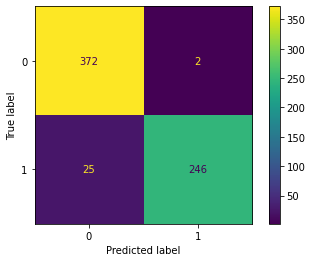

In [53]:
## Confusion matrix
from sklearn.metrics import plot_confusion_matrix

#y_pred = clf.predict(X)
plot_confusion_matrix(clf,X, y)

In [58]:
y_test

50563     0
208595    0
10897     1
9487      1
57615     1
         ..
12369     1
184116    0
241445    1
42756     1
73857     1
Name: Class, Length: 197, dtype: int64

In [59]:
# lets check on what we cares us. TEST data!

test_pred=clf.predict(test) 

target_names = ["FRAUD","NO FRAUD"]

print(classification_report(y_test, test_pred,target_names=target_names))

              precision    recall  f1-score   support

       FRAUD       0.85      0.99      0.92        99
    NO FRAUD       0.99      0.83      0.90        98

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197



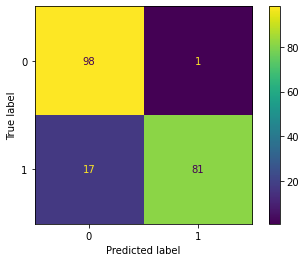

In [55]:


plot_confusion_matrix(clf,test, y_test)

##### Model 2 : Decision Trees

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
clf = RandomForestClassifier(max_depth=6, random_state=0)

clf.fit(X, y)

RandomForestClassifier(max_depth=6, random_state=0)

In [74]:
y_pred_RF= clf.predict(X)
target_names = ["FRADUD","NO FRAUD"]

print(classification_report(y, y_pred_RF,target_names=target_names))

              precision    recall  f1-score   support

      FRADUD       0.96      1.00      0.98       374
    NO FRAUD       1.00      0.94      0.97       271

    accuracy                           0.97       645
   macro avg       0.98      0.97      0.97       645
weighted avg       0.97      0.97      0.97       645



In [75]:
## IN TEST 

test_pred_RF=clf.predict(test) 

target_names = ["FRAUD","NO FRAUD"]

print(classification_report(y_test, test_pred_RF,target_names=target_names))

              precision    recall  f1-score   support

       FRAUD       0.86      0.99      0.92        99
    NO FRAUD       0.99      0.84      0.91        98

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197

